# **Lab 8**

## **Question 1. [65 marks]**
Independent component analysis (ICA) is used to estimate sources given noisy measurements.
ICA is a computational method for separating a multivariate signal into its underlying
components. Using ICA, we can extract the desired component (i.e. conversation between you
and some other person) from the amalgamation of multiple signals.
Download files from the link Music and perform the following tasks
The folder contains three signal files of piano, music and some noise respectively.


1) Read, Visualize and Listen the audio files. [5 marks]

In [ ]:
import wave
import IPython.display as ipd
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn.utils import shuffle
import torch
import torch.nn as nn
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore")

audios = [None, None, None]
audios[0] = np.fromstring(wave.open('/content/drive/MyDrive/Colab Notebooks/Lab 8/signal_1.wav', 'r').readframes(-1), 'int16')
audios[1] = np.fromstring(wave.open('/content/drive/MyDrive/Colab Notebooks/Lab 8/signal_2.wav', 'r').readframes(-1), 'int16')
audios[2] = np.fromstring(wave.open('/content/drive/MyDrive/Colab Notebooks/Lab 8/signal_3.wav', 'r').readframes(-1), 'int16')

for i in range(3):
    audios[i] = audios[i]/np.max(audios[i])
    mean = np.mean(audios[i])
    audios[i]-=mean

ipd.Audio(audios[0], rate=44100)

In [ ]:
ipd.Audio(audios[1], rate=44100)

In [ ]:
ipd.Audio(audios[2], rate=44100)

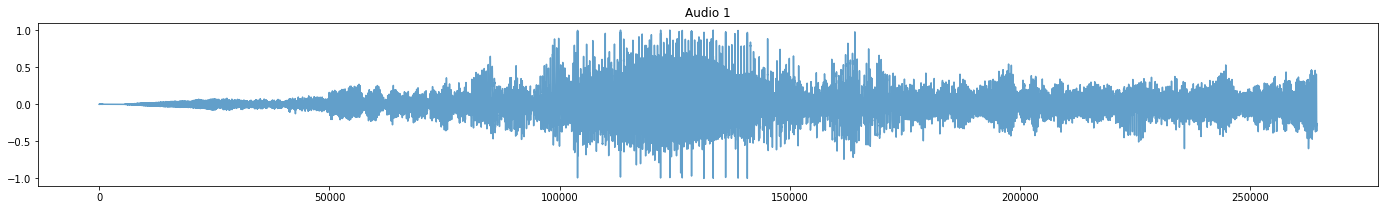

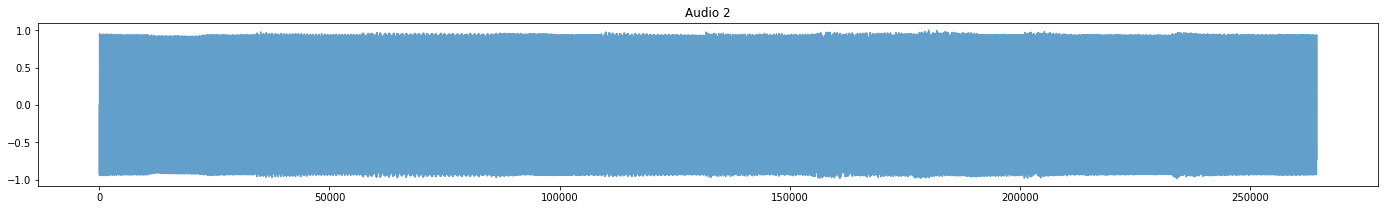

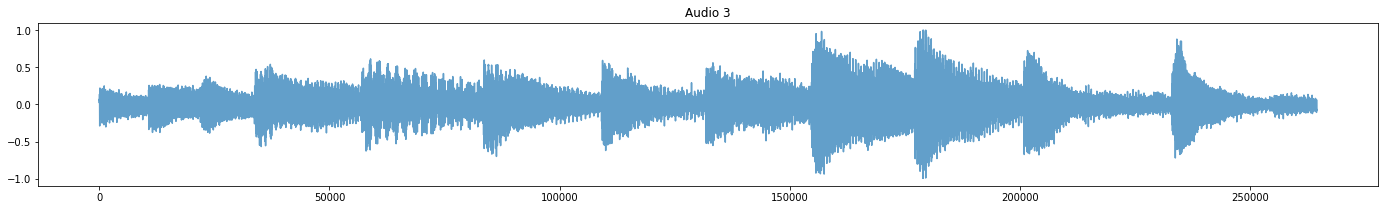

In [ ]:
for i in range(3):
    plt.figure(figsize=(24,3))
    plt.title(f'Audio {i+1}')
    plt.plot(audios[i], alpha = 0.7)
    plt.show()


2) Extract raw audio from the three wave files and merge them to create dataset X.
[5 marks]

In [ ]:
d = [x for x in audios]
S = np.array(d).T                               # Original Sources
print(S.T)

A = np.array([[1,0.1,0.5],[0.4,1,0.4],[0.5,0.1,1]]) # mixing matrix
X = S.dot(A).T

[[ 3.48700350e-04  5.62564882e-04  1.95939970e-04 ... -2.73733974e-01
  -2.79630524e-01 -2.83724502e-01]
 [-5.33766682e-03 -6.40525098e-02 -1.20919683e-01 ... -6.48018841e-01
  -6.89078172e-01 -7.27879239e-01]
 [ 6.56457080e-02  7.13381334e-02  6.16059223e-02 ...  3.97543538e-02
   4.08561135e-02  5.37711862e-02]]



3) Implement ICA from scratch. For Convergence select either 1000 iterations, or when the
dot product of w (demixing matrix) and its transpose is roughly equal to 1.

[35 marks]

In [ ]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean 
    return centered, mean

def whiten(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean
    coVarM = (m.dot(m.T))/n
    U, S, V = np.linalg.svd(coVarM)
    d = np.diag(1.0 / np.sqrt(S)) 
    whiteM = np.dot(U, np.dot(d, U.T))
    Xw = np.dot(whiteM, X) 
    return Xw, whiteM

def ICA(signals,  alpha = 1, thresh=1e-8, iterations=1000):
    m, n = signals.shape
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):
                ws = np.dot(w.T, signals)
                wg = np.tanh(ws * alpha).T
                wg_ = (1 - np.square(np.tanh(ws))) * alpha
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())
                lim = np.abs(np.abs((wNew * w).sum()) - 1)
                w = wNew
                i += 1

            W[c, :] = w.T
    return W


Xc, meanX = center(X)
Xw, whiteM = whiten(Xc)

W = ICA(Xw,  alpha=1)

unMixed = Xw.T.dot(W.T)
unMixed = (unMixed.T - meanX).T


4) Plot mixture, real source and predicted source from the output of ICA. [5 marks]

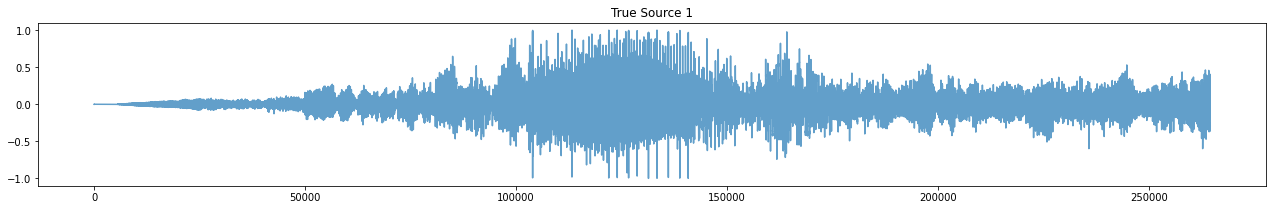

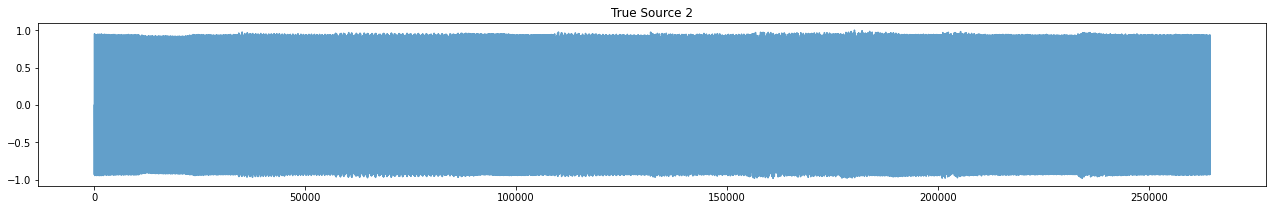

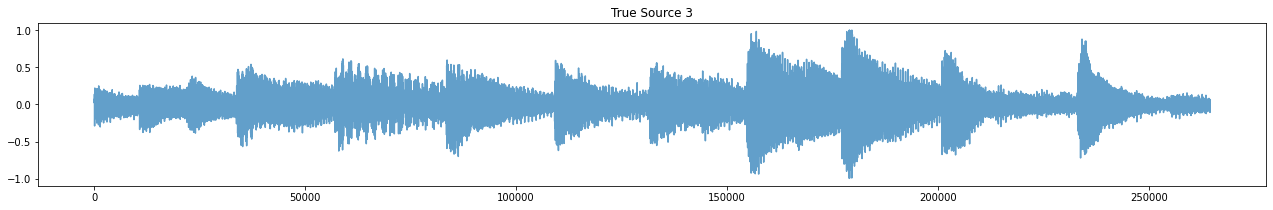

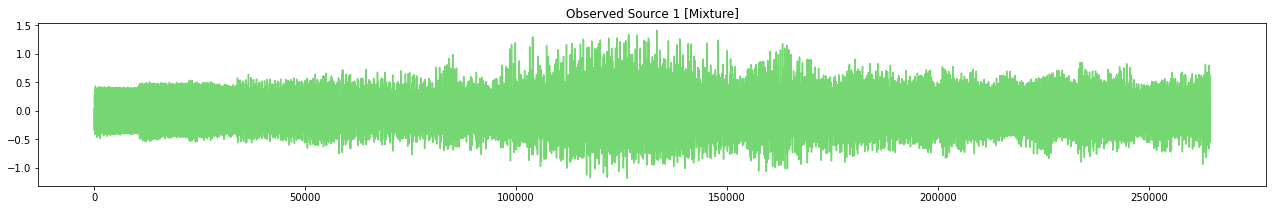

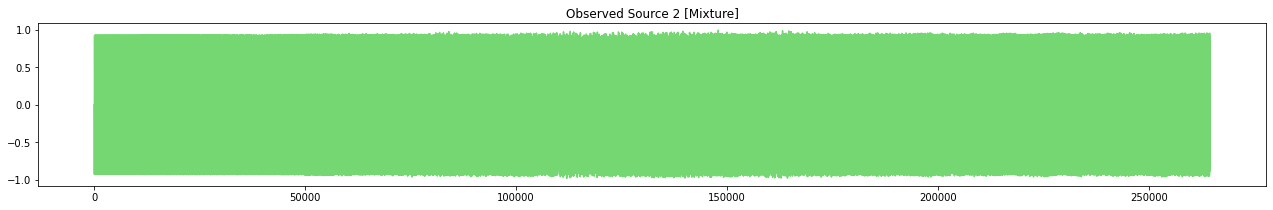

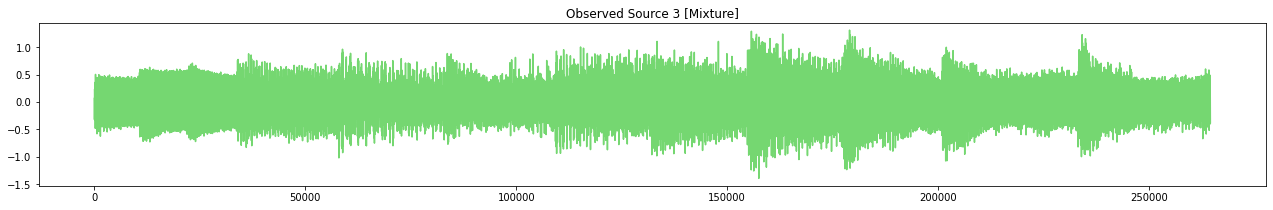

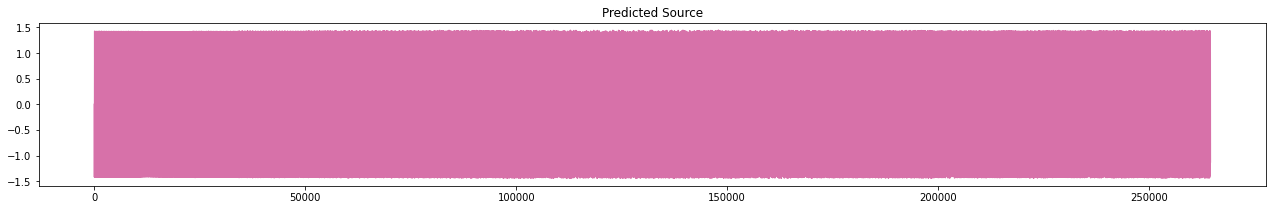

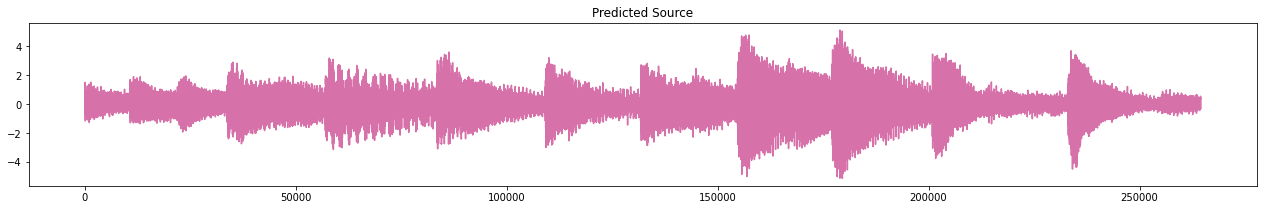

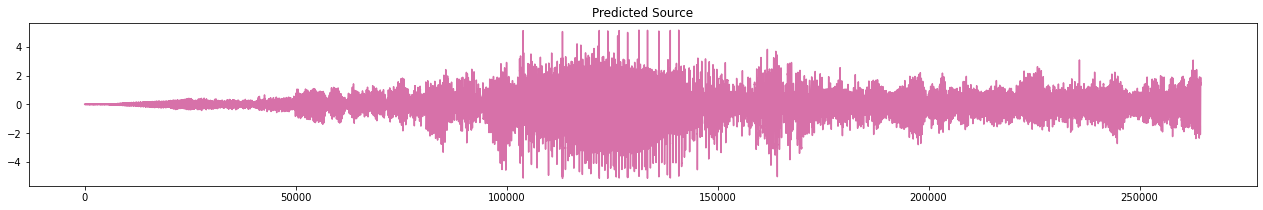

In [ ]:
for i in range(3):
    plt.figure(figsize=(22,3))
    plt.title(f'True Source {i+1}')
    plt.plot(audios[i], alpha = 0.7)
    plt.show()

for i in range(3):
    plt.figure(figsize=(22,3))
    plt.title(f'Observed Source {i+1} [Mixture]')
    plt.plot(X[i,:],c='#3ac735', alpha = 0.7)
    plt.show()

for i in range(3):
    plt.figure(figsize=(22,3))
    plt.title(f'Predicted Source')
    plt.plot(unMixed[:,i],c='#c73585', alpha = 0.7)
    plt.show()

plt.show()


5) Implement Fast ICA (import from sklearn.decomposition) selecting num_components =
3 [5 marks]

In [ ]:
from sklearn.decomposition import FastICA

A = np.array([[1,0.5,0.8],[0.4,1,0.4],[0.8,0.5,1]])     # mixing matrix
S_mixed = np.dot(S,A)                                   # Observed Sources

transformer = FastICA(n_components=3, random_state=0)
S_preds = transformer.fit_transform(S_mixed)            # Predicted Sources
print(S_preds)

[[ 5.22071246e-07  1.58147513e-05 -6.54762045e-04]
 [-1.25125368e-06  1.90382230e-04 -7.11599459e-04]
 [ 1.84420543e-06  3.59489085e-04 -6.14538337e-04]
 ...
 [ 2.74333802e-03  1.93773378e-03 -3.69491200e-04]
 [ 2.80245700e-03  2.06005315e-03 -3.79917445e-04]
 [ 2.84424934e-03  2.17557810e-03 -5.08344056e-04]]



6) Separate, Visualize and Listen the independent component obtained from task 5.
[5 marks]

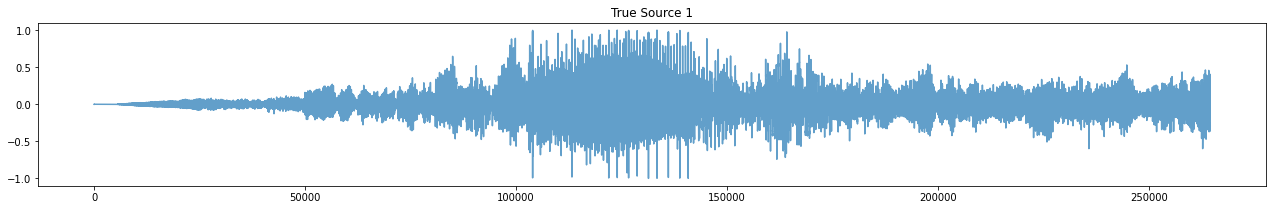

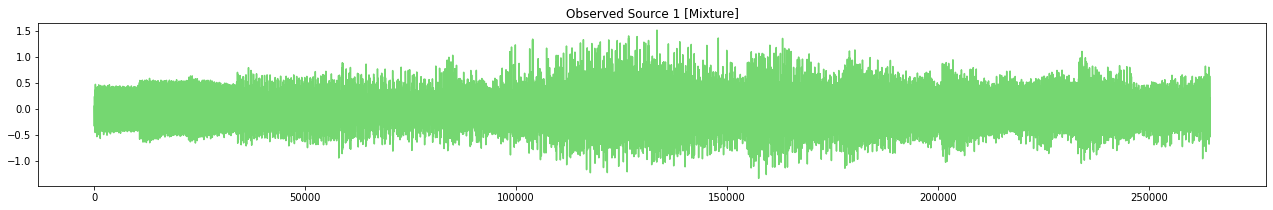

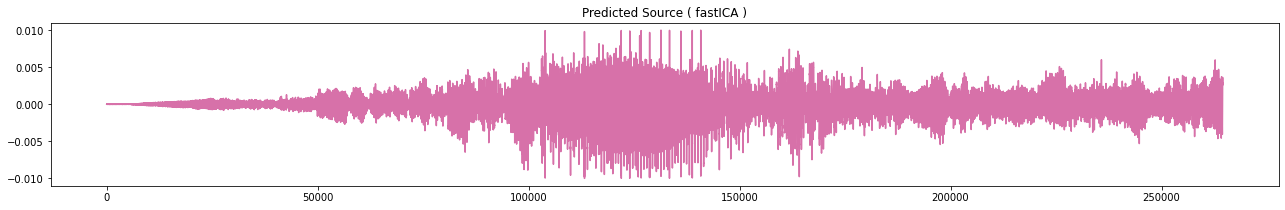

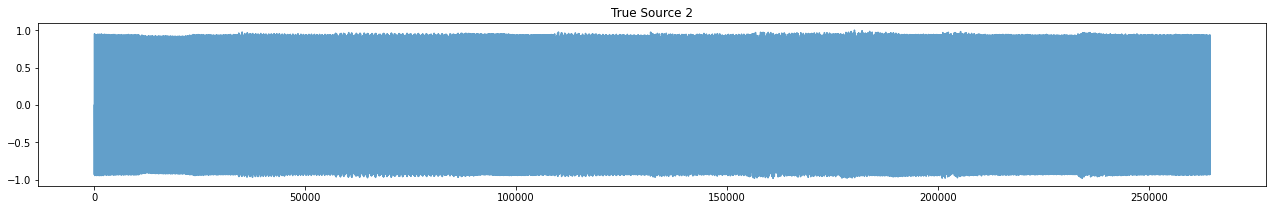

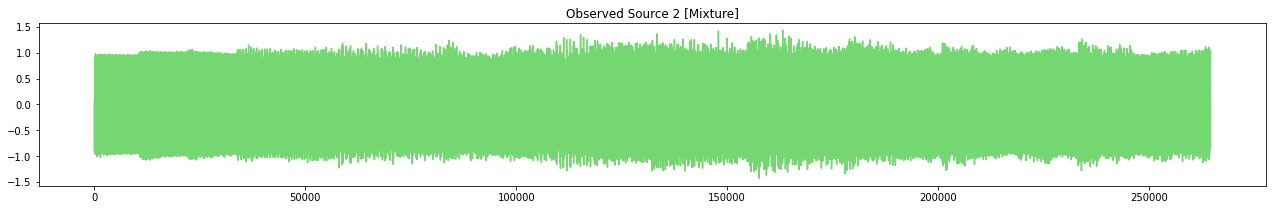

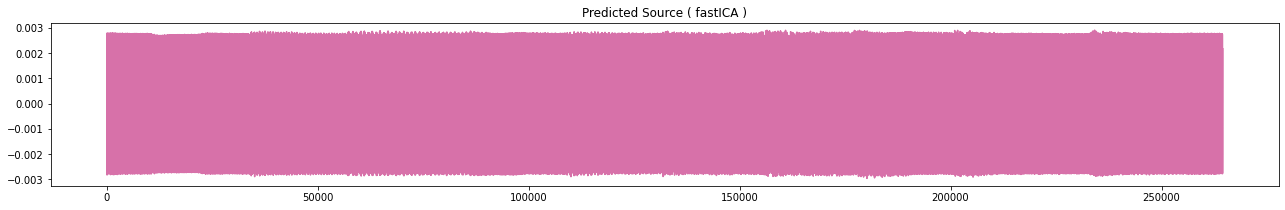

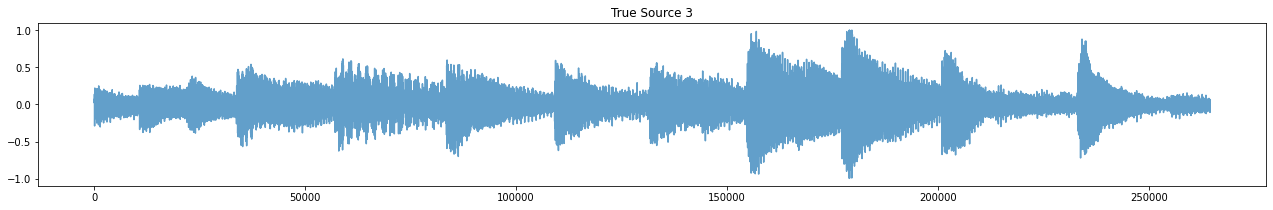

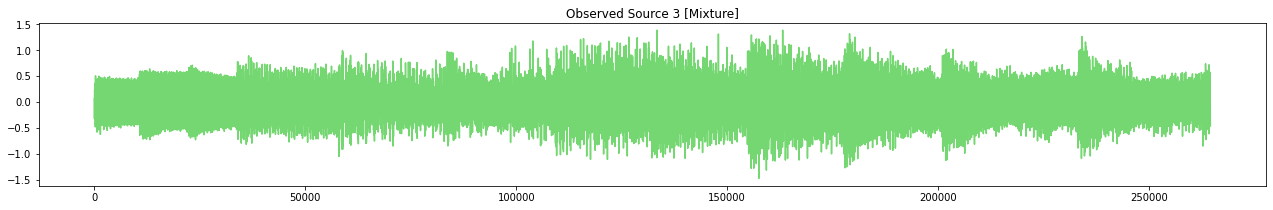

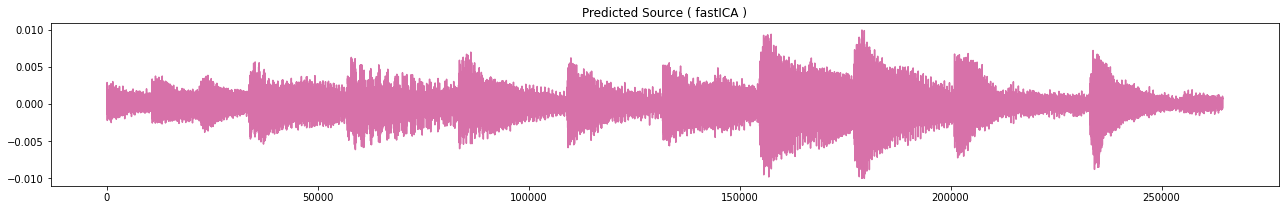

In [ ]:
for i in range(3):
    plt.figure(figsize=(22,3))
    plt.title(f'True Source {i+1}')
    plt.plot(audios[i], alpha = 0.7)
    plt.show()
    plt.figure(figsize=(22,3))
    plt.title(f'Observed Source {i+1} [Mixture]')
    plt.plot(S_mixed[:,i],c='#3ac735', alpha = 0.7)
    plt.show()
    plt.figure(figsize=(22,3))
    plt.title(f'Predicted Source ( fastICA )')
    plt.plot(S_preds[:,i],c='#c73585', alpha = 0.7)
    plt.show()

In [ ]:
print('Predicted Audio for File 1:')
ipd.Audio(S_preds[:,0].ravel(),rate=44100)

Predicted Audio for File 1:


In [ ]:
print('Predicted Audio for File 2:')
ipd.Audio(S_preds[:,1].ravel(),rate=44100)

Predicted Audio for File 2:


In [ ]:
print('Predicted Audio for File 3:')
ipd.Audio(S_preds[:,2].ravel(),rate=44100)

Predicted Audio for File 3:



7) Comment on the results obtained from ICA and Fast ICA and report observations in the
report. [5 marks]

> * <i> We see that both ICA and FastICA predicts almost same results [From Plots].
> * Both the algorithms are almost similar but former is slower and takes up more memory than FastICA [Googled].</i>


Note: For task 3 only you need to implement from scratch, for the other tasks you can
use predefined libraries.

# **Question 2. [35 marks]**
Sequential feature selection algorithms are a family of greedy search algorithms that are used to
reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d.
The motivation behind feature selection algorithms is to automatically select a subset of features
that is most relevant to the problem.
In a nutshell, SFAs remove or add one feature at the time based on the classifier performance
until a feature subset of the desired size k is reached.
Install the below library for using SFS algorithms.
pip install mlxtend
Import SFS using the below
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
Download dataset from the given link AirlinePassenger and perform the following tasks
There is a separate file for train and test. Download only the train.csv file.


1) Preprocess, clean and prepare the dataset based on the previous lab experience.
Separate features and labels as X and Y respectively. [5 marks]

In [1]:
import wave
import IPython.display as ipd
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeClassifier as DTC
import warnings
warnings.filterwarnings("ignore")

df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lab 8/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lab 8/test.csv')

df_train.set_index(df_train['id'],inplace=True)
df_test.set_index(df_test['id'],inplace=True)
df_train.drop(['Unnamed: 0','id'],inplace=True,axis=1)
df_test.drop(['Unnamed: 0','id'],inplace=True,axis=1)

cate = ['Gender','Customer Type','Type of Travel','Class','satisfaction']
not_cont = cate + ['id']
cols = df_train.columns

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

for f in cate:
    df_train[f] = preprocessing.LabelEncoder().fit_transform(df_train[f])

for f in df_train.columns:
    if f not in not_cont:
        df_train[f] = preprocessing.MinMaxScaler().fit_transform(pd.DataFrame(df_train[f]))

X_train, Y_train = df_train.iloc[:,:-1],df_train.iloc[:,-1]
X_test, Y_test = df_test.iloc[:,:-1],df_test.iloc[:,-1]

df_train.head()

Gender  Customer Type       Age  Type of Travel  Class  \
id                                                               
70172        1              0  0.076923               1      2   
5047         1              1  0.230769               0      0   
110028       0              0  0.243590               0      0   
24026        0              0  0.230769               0      0   
119299       1              0  0.692308               0      0   

        Flight Distance  Inflight wifi service  \
id                                               
70172          0.086632                    0.6   
5047           0.041195                    0.6   
110028         0.224354                    0.4   
24026          0.107229                    0.4   
119299         0.036955                    0.6   

        Departure/Arrival time convenient  Ease of Online booking  \
id                                                                  
70172                                 0.8                     0.6   
5047                                  0.4                     0.6   
110028                                0.4                     0.4   
24026                                 1.0                     1.0   
119299                                0.6                     0.6   

        Gate location  ...  Inflight entertainment  On-board service  \
id                     ...                                             
70172             0.2  ...                     1.0               0.8   
5047              0.6  ...                     0.2               0.2   
110028            0.4  ...                     1.0               0.8   
24026             1.0  ...                     0.4               0.4   
119299            0.6  ...                     0.6               0.6   

        Leg room service  Baggage handling  Checkin service  Inflight service  \
id                                                                              
70172                0.6              0.75              0.8               1.0   
5047                 1.0              0.50              0.2               0.8   
110028               0.6              0.75              0.8               0.8   
24026                1.0              0.50              0.2               0.8   
119299               0.8              0.75              0.6               0.6   

        Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                          
70172           1.0                    0.015704                  0.011364   
5047            0.2                    0.000628                  0.003788   
110028          1.0                    0.000000                  0.000000   
24026           0.4                    0.006910                  0.005682   
119299          0.6                    0.000000                  0.000000   

        satisfaction  
id                    
70172              0  
5047               0  
110028             1  
24026              0  
119299             1  

[5 rows x 23 columns]


2) Create an object of SFS by embedding Decision Tree classifier object, providing 10
features, forward as True, floating as False and scoring = accuracy. [5 marks]


In [2]:

class scratch_SFS():

    def __init__(self,model=DTC(), k_features=10):
        self.base_model = model
        self.k_features = k_features
        self.f_names = []
        self.accuracies = []

    def fit(self, X_train, Y_train):
        col_list = list(X_train.columns)
        df_train = pd.concat([X_train,Y_train],axis=1)
        df_pos=df_train[df_train["satisfaction"]==1]
        df_neg=df_train[df_train["satisfaction"]==0]

        df_pos_splits=np.array_split(df_pos,self.k_features)
        df_neg_splits=np.array_split(df_neg,self.k_features)

        dump = []
        dump_accs = []
        max_acc_before=0

        for i in range(len(df_pos_splits)):

            if len(self.f_names)>self.k_features:
                break

            testing_pos=df_pos_splits[i]
            testing_neg=df_neg_splits[i]
            frames=[testing_pos, testing_neg]
            testing_full=pd.concat(frames)


            if i==0:
                training_pos=df_pos_splits[i+1:]
                training_pos_full=pd.concat(training_pos)
                training_neg=df_neg_splits[i+1:]
                training_neg_full=pd.concat(training_neg)
                frames=[training_pos_full,training_neg_full]
                training_full=pd.concat(frames)

            else:
                training_pos=df_pos_splits[0:i]+df_pos_splits[i+1:]
                training_pos_full=pd.concat(training_pos)
                training_neg=df_neg_splits[0:i]+df_neg_splits[i+1:]
                training_neg_full=pd.concat(training_neg)
                frames=[training_pos_full,training_neg_full]
                training_full=pd.concat(frames)

            class_label_train=training_full['satisfaction']
            class_label_test=testing_full['satisfaction']
            a = (class_label_train.values)
            
            dic_feature_acc={}
            for col in col_list:

                self.f_names.append(col)

                curr_feature=training_full[self.f_names]
                curr_test_feature=testing_full[self.f_names]
                clf = self.base_model
                clf.fit(curr_feature,class_label_train)
                avg_acc=clf.score(curr_test_feature,class_label_test)

                self.f_names.remove(col)
                if col not in dic_feature_acc.keys():
                    dic_feature_acc[col]=[avg_acc]
                else:
                    dic_feature_acc[col].append(avg_acc)

            dic_avgfold_acc={}    
            max_acc=0
            feature=""
            
            for key,value in dic_feature_acc.items():
                avg=np.mean(value)
                
                if avg>max_acc:
                    max_acc=avg
                    feature=key
            
            if max_acc>max_acc_before:
                self.f_names.append(feature)
                self.accuracies.append(round(max_acc,4))
                col_list.remove(feature)
                max_acc_before=max_acc
            else:
                dump.append(feature)
                dump_accs.append(round(max_acc,4))
                col_list.remove(feature)

        for i in range(self.k_features-len(self.f_names)):
            self.f_names.append(dump[i])
            self.accuracies.append(dump_accs[i])
            self.accuracies.sort()
    
    def give_features(self):
        print(f'Selected {self.k_features} Features are :')
        print(self.f_names,end='\n\n')
        print(f'Accuracies for the Selected Features :')
        print(self.accuracies)

3) Train SFS and report accuracy for all 10 features. Also list the names of the 10 best
features selected by SFS. [5 marks]

In [49]:
scratch_sfs = scratch_SFS(model=DTC(), k_features=10)
scratch_sfs.fit(X_train,Y_train)

scratch_sfs.give_features()

# f_names= list(model.k_feature_names_)
# metr = model.subsets_
# accs_10 = []

# for i in metr:
#     accs_10.append(round(metr[i]['avg_score'],4))

# print(f'Accuracies : \n{accs_10}')
# print(f'\nFeature names : \n{f_names}')

Selected 10 Features are :
['Online boarding', 'Type of Travel', 'Inflight wifi service', 'Gate location', 'Inflight service', 'Customer Type', 'Class', 'Baggage handling', 'Seat comfort', 'Inflight entertainment']

Accuracies for the Selected Features :
[0.784, 0.8503, 0.8919, 0.9245, 0.9284, 0.9409, 0.951, 0.9511, 0.9528, 0.9535]



4) Using the forward and Floating parameter toggle between SFS(forward True, floating
False), SBS (forward False, floating False), SFFS (forward True, floating True), SBFS
(forward False, floating True), and choose cross validation = 4 for each configuration.
Also report cv scores for each configuration. [5 marks]

In [6]:
sfs = SFS(DTC(), k_features=10, forward = True, floating = False, scoring= 'accuracy', cv=4)
sfs.fit(X_train,Y_train)
cv_sfs = (sfs.subsets_)[10]["cv_scores"]

sbs = SFS(DTC(), k_features=10, forward = False, floating = False, scoring= 'accuracy', cv=4)
sbs.fit(np.array(X_train),np.array(Y_train), custom_feature_names=list(X_train.columns))
cv_sbs = (sbs.subsets_)[10]["cv_scores"]

sffs = SFS(DTC(), k_features=10, forward = True, floating = True, scoring= 'accuracy', cv=4)
sffs.fit(np.array(X_train),np.array(Y_train), custom_feature_names=list(X_train.columns))
cv_sffs = (sffs.subsets_)[10]["cv_scores"]

sbfs = SFS(DTC(), k_features=10, forward = False, floating = True, scoring= 'accuracy', cv=4)
sbfs.fit(np.array(X_train),np.array(Y_train), custom_feature_names=list(X_train.columns))
cv_sbfs = (sbfs.subsets_)[10]["cv_scores"]

In [13]:
print(f'CV Scores for SFS:\n{cv_sfs} ,\tMean Accuracy = {np.mean(cv_sfs):.4f}\n')
print(f'CV Scores for SBS:\n{cv_sbs} ,\tMean Accuracy = {np.mean(cv_sbs):.4f}\n')
print(f'CV Scores for SFFS:\n{cv_sffs} ,\tMean Accuracy = {np.mean(cv_sffs):.4f}\n')
print(f'CV Scores for SBFS:\n{cv_sbfs} ,\tMean Accuracy = {np.mean(cv_sbfs):.4f}\n')

CV Scores for SFS:
[0.94903278 0.95007529 0.9501892  0.95177234] ,	Mean Accuracy = 0.9503

CV Scores for SBS:
[0.94883972 0.95022974 0.94953278 0.95188818] ,	Mean Accuracy = 0.9501

CV Scores for SFFS:
[0.95065447 0.95146531 0.95057533 0.95281489] ,	Mean Accuracy = 0.9514

CV Scores for SBFS:
[0.94737249 0.94694776 0.94764074 0.9498803 ] ,	Mean Accuracy = 0.9480




5) Visualize the output from the feature selection in a pandas DataFrame format using the
get_metric_dict for all four configurations. [5 marks]

In [21]:
print('For SFS :')
pd.DataFrame(sfs.get_metric_dict()).T

For SFS :


feature_idx  \
1                                 (11,)   
2                               (3, 11)   
3                            (3, 6, 11)   
4                         (3, 6, 9, 11)   
5                      (1, 3, 6, 9, 11)   
6                  (1, 3, 6, 9, 11, 16)   
7               (1, 3, 4, 6, 9, 11, 16)   
8           (1, 3, 4, 6, 9, 11, 16, 18)   
9       (1, 3, 4, 6, 9, 11, 12, 16, 18)   
10  (1, 3, 4, 6, 9, 11, 12, 13, 16, 18)   

                                            cv_scores avg_score  \
1   [0.7897602224024094, 0.7918066334607514, 0.793...  0.790335   
2   [0.8483339125062743, 0.8511911656820726, 0.850...  0.849615   
3   [0.8914629908490675, 0.8920421637901077, 0.892...  0.891249   
4   [0.9192246804895942, 0.9228927757828488, 0.922...  0.921733   
5   [0.9277578284875864, 0.9284914475462374, 0.929...  0.928828   
6   [0.9393412873083903, 0.9425846557782154, 0.939...    0.9413   
7   [0.946368585659678, 0.9487625004826441, 0.9485...   0.94824   
8   [0.9497664002471138, 0.9503841847175567, 0.950...  0.950673   
9   [0.9491486157766709, 0.9509247461291942, 0.951...  0.950866   
10  [0.9490327811884629, 0.9500752924823352, 0.950...  0.950267   

                                        feature_names  ci_bound   std_dev  \
1                                  (Online boarding,)  0.004065  0.002536   
2                   (Type of Travel, Online boarding)  0.002085    0.0013   
3   (Type of Travel, Inflight wifi service, Online...  0.002214  0.001381   
4   (Type of Travel, Inflight wifi service, Gate l...  0.002346  0.001463   
5   (Customer Type, Type of Travel, Inflight wifi ...  0.001202   0.00075   
6   (Customer Type, Type of Travel, Inflight wifi ...  0.002925  0.001825   
7   (Customer Type, Type of Travel, Class, Infligh...  0.001789  0.001116   
8   (Customer Type, Type of Travel, Class, Infligh...  0.001128  0.000704   
9   (Customer Type, Type of Travel, Class, Infligh...  0.001748  0.001091   
10  (Customer Type, Type of Travel, Class, Infligh...  0.001569  0.000979   

     std_err  
1   0.001464  
2   0.000751  
3   0.000797  
4   0.000845  
5   0.000433  
6   0.001053  
7   0.000645  
8   0.000406  
9    0.00063  
10  0.000565

In [20]:
print('For SBS :')
pd.DataFrame(sbs.get_metric_dict()).T

For SBS :


feature_idx  \
22  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
21  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
20  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
19  (1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 1...   
18  (1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 1...   
17  (1, 2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, ...   
16  (1, 2, 3, 4, 6, 9, 11, 12, 13, 14, 15, 16, 17,...   
15  (1, 2, 3, 4, 6, 9, 11, 12, 13, 15, 16, 17, 18,...   
14  (1, 2, 3, 4, 6, 9, 11, 12, 13, 15, 16, 17, 18,...   
13     (1, 2, 3, 4, 6, 9, 11, 12, 13, 15, 16, 17, 18)   
12        (1, 3, 4, 6, 9, 11, 12, 13, 15, 16, 17, 18)   
11            (1, 3, 4, 6, 9, 11, 12, 13, 16, 17, 18)   
10                (1, 3, 4, 6, 9, 11, 12, 13, 16, 18)   

                                            cv_scores avg_score  \
22  [0.9433182748368663, 0.9462141395420672, 0.945...  0.945344   
21  [0.9439360593073092, 0.945403297424611, 0.9465...  0.945943   
20  [0.9445152322483493, 0.9447855129541681, 0.946...   0.94603   
19  [0.9456349666010271, 0.946484420247886, 0.9460...  0.946397   
18  [0.945287462836403, 0.9469091470713155, 0.9467...  0.946754   
17  [0.9443607861307386, 0.9480674929533959, 0.944...  0.946339   
16  [0.9462527510714699, 0.9486852774238388, 0.944...  0.947063   
15  [0.9460210818950539, 0.9466774778948994, 0.945...   0.94629   
14  [0.9440132823661145, 0.9452488513070003, 0.943...  0.945248   
13  [0.944438009189544, 0.9451330167187922, 0.9453...  0.945219   
12  [0.9444766207189467, 0.9441291169543226, 0.944...  0.945045   
11  [0.9479130468357851, 0.9482605506004093, 0.946...  0.948028   
10  [0.9488397235414495, 0.950229738599946, 0.9495...  0.950123   

                                        feature_names  ci_bound   std_dev  \
22  (Gender, Customer Type, Age, Type of Travel, C...   0.00194   0.00121   
21  (Gender, Customer Type, Age, Type of Travel, C...  0.002326  0.001451   
20  (Customer Type, Age, Type of Travel, Class, Fl...  0.002599  0.001621   
19  (Customer Type, Age, Type of Travel, Class, Fl...  0.001054  0.000657   
18  (Customer Type, Age, Type of Travel, Class, Fl...  0.001603     0.001   
17  (Customer Type, Age, Type of Travel, Class, In...  0.003386  0.002112   
16  (Customer Type, Age, Type of Travel, Class, In...  0.002578  0.001608   
15  (Customer Type, Age, Type of Travel, Class, In...  0.000857  0.000534   
14  (Customer Type, Age, Type of Travel, Class, In...  0.002656  0.001657   
13  (Customer Type, Age, Type of Travel, Class, In...  0.000881   0.00055   
12  (Customer Type, Type of Travel, Class, Infligh...   0.00209  0.001304   
11  (Customer Type, Type of Travel, Class, Infligh...  0.002134  0.001331   
10  (Customer Type, Type of Travel, Class, Infligh...  0.001814  0.001132   

     std_err  
22  0.000699  
21  0.000838  
20  0.000936  
19  0.000379  
18  0.000577  
17   0.00122  
16  0.000929  
15  0.000309  
14  0.000957  
13  0.000317  
12  0.000753  
11  0.000769  
10  0.000653

In [19]:
print('For SFFS :')
pd.DataFrame(sffs.get_metric_dict()).T

For SFFS :


feature_idx  \
1                                  (11,)   
2                                (3, 11)   
3                             (3, 6, 11)   
4                          (3, 6, 9, 11)   
5                       (1, 3, 6, 9, 11)   
6                   (1, 3, 6, 9, 11, 16)   
7                (1, 3, 4, 6, 9, 11, 16)   
8            (1, 3, 4, 6, 9, 11, 16, 18)   
9       (1, 3, 4, 6, 11, 12, 13, 16, 18)   
10  (1, 3, 4, 6, 11, 12, 13, 16, 18, 19)   

                                            cv_scores avg_score  \
1   [0.7897602224024094, 0.7918066334607514, 0.793...  0.790335   
2   [0.8483339125062743, 0.8511911656820726, 0.850...  0.849615   
3   [0.8914629908490675, 0.8920421637901077, 0.892...  0.891249   
4   [0.9192246804895942, 0.9228927757828488, 0.922...  0.921733   
5   [0.9277578284875864, 0.9284914475462374, 0.929...  0.928828   
6   [0.9393412873083903, 0.9424688211900073, 0.939...  0.941271   
7   [0.9463299741302753, 0.9488397235414495, 0.948...  0.948289   
8   [0.949496119541295, 0.9504227962469594, 0.9508...  0.950634   
9   [0.9501525155411406, 0.9508475230703888, 0.949...  0.950769   
10  [0.9506544654233754, 0.9514653075408317, 0.950...  0.951377   

                                        feature_names  ci_bound   std_dev  \
1                                  (Online boarding,)  0.004065  0.002536   
2                   (Type of Travel, Online boarding)  0.002085    0.0013   
3   (Type of Travel, Inflight wifi service, Online...  0.002214  0.001381   
4   (Type of Travel, Inflight wifi service, Gate l...  0.002346  0.001463   
5   (Customer Type, Type of Travel, Inflight wifi ...  0.001202   0.00075   
6   (Customer Type, Type of Travel, Inflight wifi ...  0.002893  0.001805   
7   (Customer Type, Type of Travel, Class, Infligh...   0.00189  0.001179   
8   (Customer Type, Type of Travel, Class, Infligh...   0.00133   0.00083   
9   (Customer Type, Type of Travel, Class, Infligh...  0.001358  0.000847   
10  (Customer Type, Type of Travel, Class, Infligh...  0.001443    0.0009   

     std_err  
1   0.001464  
2   0.000751  
3   0.000797  
4   0.000845  
5   0.000433  
6   0.001042  
7   0.000681  
8   0.000479  
9   0.000489  
10   0.00052

In [18]:
print('For SBFS :')
pd.DataFrame(sbfs.get_metric_dict()).T

For SBFS :


feature_idx  \
22  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
21  (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
20  (0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 1...   
19  (0, 1, 2, 3, 4, 6, 9, 10, 11, 12, 13, 14, 15, ...   
18  (1, 2, 3, 4, 6, 9, 10, 11, 12, 13, 14, 15, 16,...   
17  (1, 2, 3, 4, 6, 9, 10, 11, 12, 13, 14, 15, 16,...   
16  (1, 2, 3, 4, 6, 9, 11, 12, 13, 14, 15, 16, 17,...   
15  (1, 2, 3, 4, 6, 9, 11, 12, 13, 14, 15, 16, 17,...   
14  (1, 2, 3, 4, 6, 9, 11, 12, 14, 15, 16, 17, 18,...   
13     (1, 2, 3, 4, 6, 9, 11, 12, 15, 16, 17, 18, 21)   
12         (1, 2, 3, 4, 6, 9, 11, 12, 16, 17, 18, 21)   
11             (1, 2, 3, 4, 6, 9, 11, 12, 16, 17, 18)   
10                (1, 3, 4, 6, 9, 11, 12, 16, 17, 18)   

                                            cv_scores avg_score  \
22  [0.9436657786014904, 0.945403297424611, 0.9450...  0.945132   
21  [0.9435499440132824, 0.9459052473068458, 0.946...  0.945866   
20  [0.9445538437777521, 0.9456735781304297, 0.946...  0.946039   
19  [0.9453646858952083, 0.945403297424611, 0.9452...  0.946068   
18  [0.945287462836403, 0.9469091470713155, 0.9448...  0.946541   
17  [0.945287462836403, 0.9479902698945906, 0.9456...  0.946956   
16  [0.9461369164832619, 0.9479516583651878, 0.944...  0.946609   
15  [0.9456349666010271, 0.9479130468357851, 0.943...  0.946348   
14  [0.9439746708367118, 0.9457508011892352, 0.946...   0.94573   
13  [0.943472720954477, 0.9465616433066913, 0.9460...  0.945479   
12  [0.942623267307618, 0.9457894127186378, 0.9454...  0.944813   
11  [0.9441291169543226, 0.9463299741302753, 0.944...  0.945315   
10  [0.9473724854241476, 0.9469477586007182, 0.947...   0.94796   

                                        feature_names  ci_bound   std_dev  \
22  (Gender, Customer Type, Age, Type of Travel, C...  0.001573  0.000981   
21  (Gender, Customer Type, Age, Type of Travel, C...  0.002348  0.001465   
20  (Gender, Customer Type, Age, Type of Travel, C...  0.001751  0.001092   
19  (Gender, Customer Type, Age, Type of Travel, C...  0.002066  0.001289   
18  (Customer Type, Age, Type of Travel, Class, In...  0.002712  0.001692   
17  (Customer Type, Age, Type of Travel, Class, In...   0.00243  0.001516   
16  (Customer Type, Age, Type of Travel, Class, In...  0.002366  0.001476   
15  (Customer Type, Age, Type of Travel, Class, In...  0.002834  0.001768   
14  (Customer Type, Age, Type of Travel, Class, In...  0.001737  0.001084   
13  (Customer Type, Age, Type of Travel, Class, In...  0.001906  0.001189   
12  (Customer Type, Age, Type of Travel, Class, In...  0.002042  0.001274   
11  (Customer Type, Age, Type of Travel, Class, In...  0.001848  0.001153   
10  (Customer Type, Type of Travel, Class, Infligh...  0.001821  0.001136   

     std_err  
22  0.000566  
21  0.000846  
20  0.000631  
19  0.000744  
18  0.000977  
17  0.000875  
16  0.000852  
15  0.001021  
14  0.000626  
13  0.000686  
12  0.000736  
11  0.000666  
10  0.000656


6) Finally plot the results for each configuration (from mlxtend.plotting import
plot_sequential_feature_selection as plot_sfs). [5 marks]

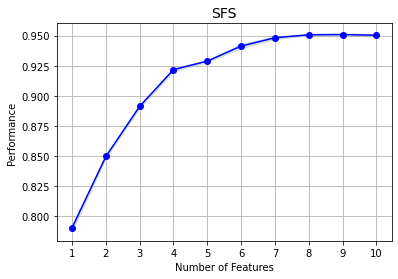

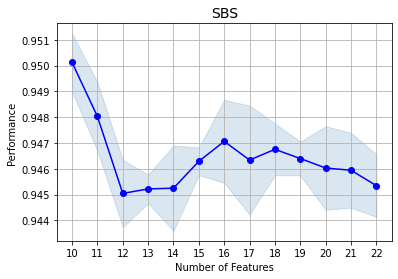

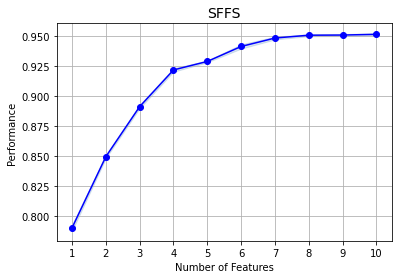

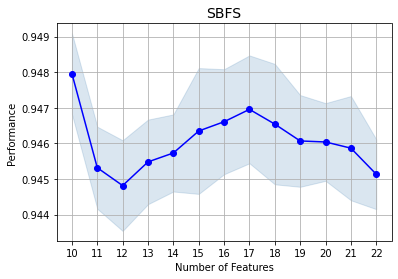

In [28]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('SFS',fontsize=14)
plt.grid()
plt.show()

fig2 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('SBS',fontsize=14)
plt.grid()
plt.show()

fig3 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
plt.title('SFFS',fontsize=14)
plt.grid()
plt.show()

fig4 = plot_sfs(sbfs.get_metric_dict(), kind='std_dev')
plt.title('SBFS',fontsize=14)
plt.grid()
plt.show()


7) For task 2 vary the features by increasing or decreasing, observe and report the results. [5 marks]

In [15]:
inc_accuracies = []
dec_accuracies = []

for i in range(5,11):                                           # we vary k_features from 5 to 10 (increasing k_features)
    curr_sfs = scratch_SFS(model=DTC(), k_features=i)
    curr_sfs.fit(X_train,Y_train)
    inc_accuracies.append(curr_sfs.accuracies[-1])

for i in range(6,1,-1):                                        # we vary k_features from 10 to 6 (decreasing k_features)
    curr_sfs = scratch_SFS(model=DTC(), k_features=i)
    curr_sfs.fit(X_train,Y_train)
    dec_accuracies.append(curr_sfs.accuracies[-1])

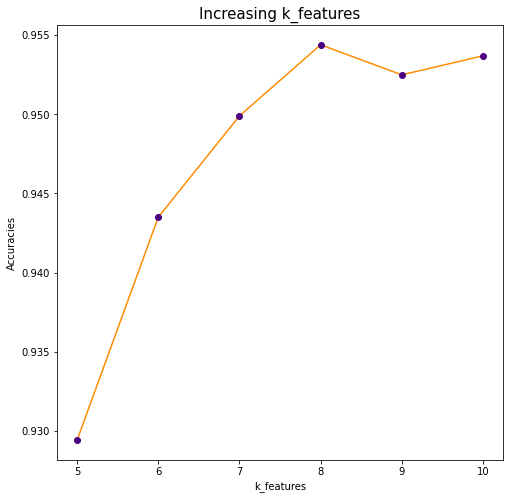

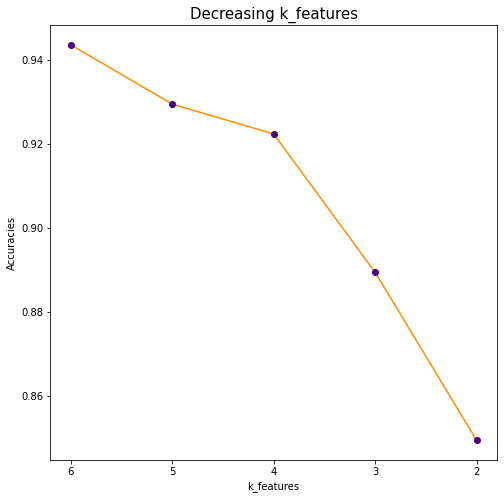

In [16]:
plt.figure(figsize=(8,8))
plt.title('Increasing k_features',fontsize=15)
plt.plot(range(5,11),inc_accuracies, 'darkorange')
plt.plot(range(5,11),inc_accuracies, marker='o',color='indigo',linewidth=0)
plt.xlabel('k_features')
plt.ylabel('Accuracies')
plt.show()

plt.figure(figsize=(8,8))
plt.title('Decreasing k_features',fontsize=15)
plt.plot([str(i) for i in range(6,1,-1)],dec_accuracies, 'darkorange')
plt.plot([str(i) for i in range(6,1,-1)],dec_accuracies, marker='o',color='indigo',linewidth=0)
plt.xlabel('k_features')
plt.ylabel('Accuracies')
plt.show()